# TSI Microscope Alignment - Image Recognition Model
This notebook outlines the process for creating a data pipeline, building and training a CNN model, and testing the results.

In [1]:
%matplotlib inline

# standard imports
from datetime import datetime as dt
import json
import os
from pathlib import Path
import queue
import threading
import time

# external dependencies
import cv2 as cv
import hyperopt as hp
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# See TensorFlow version
print(f"TensorFlow version: {tf.__version__}")
# Check for TensorFlow GPU access
print(f"TensorFlow has access to the following devices:\n{[tf.config.list_physical_devices()]}")


TensorFlow version: 2.15.0
TensorFlow has access to the following devices:
[[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]]


In [2]:
print(tf.test.is_built_with_gpu_support()) # Test install of pip package, should output True
print(tf.test.is_gpu_available()) # Should output True
print(tf.test.gpu_device_name()) # Should output something like /device:GPU:0
print(tf.config.list_physical_devices('GPU'))  # update for last test

False
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
False

[]


## Inspecting the Dataset
In this section, we'll read the dataset and plot some representative samples so we can see what the input data looks like. Then, we can look at the class distribution of the dataset.

Aligned: 16522  Not Aligned: 22428
label shape: (2,), sample shape: (128, 128)
sample type: <class 'numpy.ndarray'>, datatype: float64
max: 0.00775146484375, min: 0.00384521484375


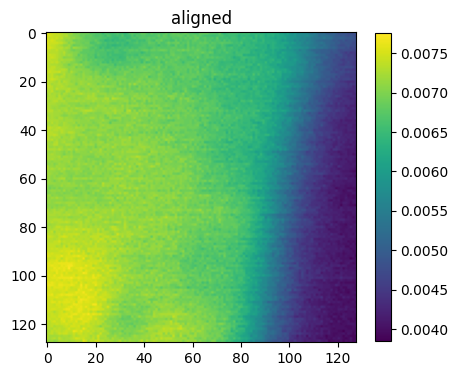

In [3]:
# inspect the training data and plot a sample image
with np.load(Path(r'C:\\Users\\hsmith\\datasets\\tsi_image_recognition\\train.npz')) as ds:
    images, labels, classes = (ds['images'], ds['labels'], ds['classes'])

# calculate the sample distribution
aligned, not_aligned = 0, 0
for img, lbl in zip(images, labels):
    if classes[np.argmax(lbl)] == 'aligned':
        aligned += 1
    else:
        not_aligned += 1

print(f"Aligned: {aligned}  Not Aligned: {not_aligned}")

# take a sample image, scaled to 16-bit int
sample = images[0]/16384.0

# print sample info
print(f"label shape: {labels[0].shape}, sample shape: {sample.shape}")
print(f"sample type: {type(sample)}, datatype: {sample.dtype}")
print(f"max: {np.max(sample)}, min: {np.min(sample)}")

# plot a sample image from the training data
fig = plt.figure(figsize=(5, 5))
ax = plt.subplot(1, 1, 1)
plt.title(f"{classes[np.argmax(labels[0])]}")
img = plt.imshow(sample, vmin=np.min(sample), vmax=np.max(sample))

fig.colorbar(img, ax=ax, shrink=0.8)

## Data Processing Pipeline
In order to train the model, we want to have consistency among the dataset. The following section defines a pipeline that will provide flexibility in how we pre-process the dataset to prepare it for training.

In [4]:
# create a data processing pipeline function
def data_pipeline(x_data, y_data, ds_path, batch_size=None, seed=123):
    """ Process the dataset """
    print('-'*80)

    np.random.seed(seed)

    print("Reading dataset from file..")
    with np.load(ds_path) as ds:
        images, labels, classes = (ds['images'], ds['labels'], ds['classes'])

    # scale images between 0-1
    print("Scaling images..")
    images = list(map(lambda x: x / 16384.0, images))

    # expand images to have dimension (H x W x D)
    print("Setting image dimensions..")
    images = list(map(lambda x: np.expand_dims(x, axis=2), images))

    # shuffle the dataset
    print("Shuffling dataset..")
    shuffled_idx = np.random.permutation(len(images))
    images, labels = np.asarray(images), np.asarray(labels)
    images[:] = images[shuffled_idx]
    labels[:] = labels[shuffled_idx]

    if batch_size is not None:
        n_batches = np.shape(images)[0] // batch_size
        print(f"Generating {n_batches} batches.")
        batched_images, batched_labels = [], []
        a = 0
        b = batch_size
        for i in range(0, n_batches):
            batched_images.append(np.asarray(images[a:b]))
            batched_labels.append(np.asarray(labels[a:b]))
            a += batch_size
            b += batch_size
        images, labels = np.asarray(batched_images), np.asarray(batched_labels)

    print('-'*80)
    # return the dataset object
    for img, lbl in zip(images, labels):
        x_data.put(img)
        y_data.put(lbl)


xq_train, yq_train = queue.Queue(), queue.Queue()
xq_val, yq_val = queue.Queue(), queue.Queue()
xq_test, yq_test = queue.Queue(), queue.Queue()

t1 = time.perf_counter()

# process the datasets
x1 = threading.Thread(target=data_pipeline,
                      args=(xq_train, yq_train, Path(r'C:\\Users\\hsmith\\datasets\\tsi_image_recognition\\train.npz')))
x2 = threading.Thread(target=data_pipeline,
                      args=(xq_val, yq_val, Path(r'C:\\Users\\hsmith\\datasets\\tsi_image_recognition\\val.npz')))
x3 = threading.Thread(target=data_pipeline,
                      args=(xq_test, yq_test, Path(r'C:\\Users\\hsmith\\datasets\\tsi_image_recognition\\test.npz')))

for thread in (x1, x2, x3):
    thread.start()

for thread in (x1, x2, x3):
    thread.join()

x_train, y_train = list(xq_train.queue), list(yq_train.queue)
x_train, y_train = np.asarray(x_train), np.asarray(y_train)
print("x_train: ")
print(x_train.shape, x_train[0].shape, x_train.dtype, type(x_train))
print("y_train: ")
print(y_train.shape, y_train[0].shape, y_train.dtype, type(y_train))

x_val, y_val = list(xq_val.queue), list(yq_val.queue)
x_val, y_val = np.asarray(x_val), np.asarray(y_val)
print("x_val: ")
print(x_val.shape, x_val[0].shape, x_val.dtype, type(x_val))
print("y_val: ")
print(y_val.shape, y_val[0].shape, y_val.dtype, type(y_val))

x_test, y_test = list(xq_test.queue), list(yq_test.queue)
x_test, y_test = np.asarray(x_test), np.asarray(y_test)
print("x_test: ")
print(x_test.shape, x_test[0].shape, x_test.dtype, type(x_test))
print("y_test: ")
print(y_test.shape, y_test[0].shape, y_test.dtype, type(y_test))

t2 = time.perf_counter()
print(f"Elapsed Time: {round(t2-t1, 4)} s")

--------------------------------------------------------------------------------
Reading dataset from file..
--------------------------------------------------------------------------------
Reading dataset from file..
--------------------------------------------------------------------------------
Reading dataset from file..
Scaling images..
Setting image dimensions..
Shuffling dataset..
Scaling images..
--------------------------------------------------------------------------------
Setting image dimensions..
Shuffling dataset..
--------------------------------------------------------------------------------
Scaling images..
Setting image dimensions..
Shuffling dataset..
--------------------------------------------------------------------------------
x_train: 
(38950, 128, 128, 1) (128, 128, 1) float64 <class 'numpy.ndarray'>
y_train: 
(38950, 2) (2,) float32 <class 'numpy.ndarray'>
x_val: 
(7209, 128, 128, 1) (128, 128, 1) float64 <class 'numpy.ndarray'>
y_val: 
(7209, 2) (2,) float3

## Model Construction
When constructing the model, we will set up the learning rate as a time-decay function to decrease overall noise in the training. Then, we will build the model and inspect the parameters. Lastly, we will configure callbacks to store and save the model, when appropriate as well as report the loss and accuracy during the training.

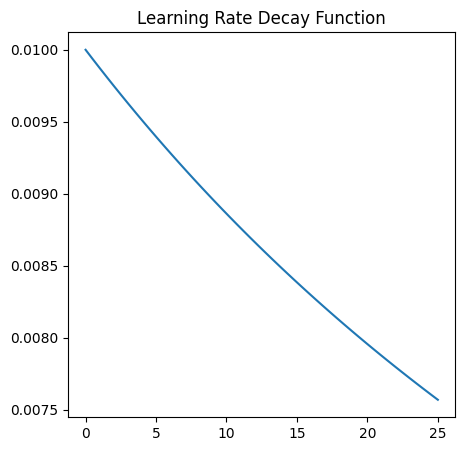

In [5]:
# set up the learning rate decay
epochs = 25

# define learning rate decay
lr_decay = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.01, decay_steps=len(x_train), decay_rate=500, staircase=False
)

# plot the learning rate
steps = np.linspace(0, epochs)

# plot learning rate decay function
plt.figure(figsize=(5, 5))
ax = plt.subplot(1, 1, 1)
plt.title(f"Learning Rate Decay Function")
plt.plot(steps, lr_decay(steps))

In [6]:
def conv_block(filters):
    k_size = (7, 7)
    p_size = (4, 4)
    stride = (2, 2)

    return tf.keras.Sequential([
        tf.keras.layers.Conv2D(filters=filters, kernel_size=k_size, padding="same", activation="relu"),
        tf.keras.layers.Conv2D(filters=filters, kernel_size=k_size, padding="same", activation="relu"),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D(pool_size=p_size, strides=stride)
    ])


In [7]:
def get_model(params):
    num_classes = 2

    block_1 = conv_block(params['block_1_filters'])
    block_2 = conv_block(params['block_2_filters'])
    block_3 = conv_block(params['block_3_filters'])

    # build the neural network model
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(128, 128, 1)),

        block_1,

        block_2,

        block_3,

        tf.keras.layers.GlobalAveragePooling2D(),

        tf.keras.layers.Dropout(params['dropout_1']),
        tf.keras.layers.Dense(params['dense_1_units'], activation='relu'),

        tf.keras.layers.Dropout(params['dropout_2']),
        tf.keras.layers.Dense(params['dense_2_units'], activation='relu'),

        tf.keras.layers.Dropout(params['dropout_3']),
        tf.keras.layers.Dense(num_classes, activation='softmax'),
    ])


    model.compile(
        loss=tf.keras.losses.CategoricalCrossentropy(),
        optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
        metrics=['accuracy'])

    # show the model summary
    model.summary()

    return model

In [8]:
def train_model(params):

    model = get_model(params)

    # create a timestamp for file naming
    curr_timestamp = dt.now().strftime("%Y%m%d_%H%M%S")
    os.mkdir(os.path.join('./models/', curr_timestamp))
    print(f"Model Name: {curr_timestamp}")

    # add checkpoint callback
    # monitor the validation loss, saving only the best model
    # only begin saving when loss is < 1.0
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        os.path.join('./models/', curr_timestamp, 'model.h5'),
        monitor='val_loss',
        verbose=1,
        save_best_only=True,
        save_weights_only=False,
        #initial_value_threshold=1.0
    )

    # add early stopping callback
    # loss must change by at least .01
    # stop after 2 epochs if no improvement
    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=.01,
        patience=5,
        verbose=1,
        mode='auto'
    )

    # run the training
    history = model.fit(
        x_train,
        y_train,
        validation_data=(x_val, y_val),
        batch_size=params['batch_size'],
        epochs=25,
        verbose=2,
        callbacks=[checkpoint, early_stop])

    # dump history to json file
    json.dump(history.history, open(os.path.join('./models/', curr_timestamp, 'history.json'), 'w'))

    # load the trained model and evaluate the model performance
    trained_model = tf.keras.models.load_model(os.path.join('./models/', curr_timestamp, 'model.h5'))
    loss, acc = trained_model.evaluate(x_test, y_test, verbose=2)

    print(f'Trained model, accuracy: {round(100*acc, 2)}%  loss: {round(loss, 4)}')

    return {'loss': loss, 'status': hp.STATUS_OK}

In [9]:
# Define the search space
search_space = {
    'batch_size': hp.hp.choice('batch_size', [128]),
    'block_1_filters': hp.hp.choice('block_1_filters', [4, 8, 16]),
    'block_2_filters': hp.hp.choice('block_2_filters', [16, 24, 32]),
    'block_3_filters': hp.hp.choice('block_3_filters', [32, 56, 64]),
    'dropout_1': hp.hp.uniform('dropout_1', 0.1, 0.5),
    'dense_1_units': hp.hp.choice('dense_1_units', [32, 64, 128, 256]),
    'dropout_2': hp.hp.uniform('dropout_2', 0.1, 0.5),
    'dense_2_units': hp.hp.choice('dense_2_units', [12, 16, 24, 32, 64]),
    'dropout_3': hp.hp.uniform('dropout_3', 0.1, 0.5)
}

# Use hyperopt to tune parameters
best_param = hp.fmin(
    fn=train_model,
    space=search_space,
    algo=hp.tpe.suggest,
    max_evals=5,
    return_argmin=False,
)

  0%|          | 0/5 [00:00<?, ?trial/s, best loss=?]



Model: "sequential_3"                                

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 sequential (Sequential)     (None, 63, 63, 8)         3576      

 sequential_1 (Sequential)   (None, 30, 30, 24)        37776     

 sequential_2 (Sequential)   (None, 14, 14, 64)        276352    

 global_average_pooling2d (  (None, 64)                0         

 GlobalAveragePooling2D)                                         

 dropout (Dropout)           (None, 64)                0         

 dense (Dense)               (None, 256)               16640     

 dropout_1 (Dropout)         (None, 256)               0         

 dense_1 (Dense)             (None, 12)                3084      

 dropout_2 (Dropout)         (None, 12)                0         

 dense_2 (Dense)             (None, 2)                 26        


Total params: 337454 (1.29 MB)                       

Trainable param

c:\Users\hsmith\repos\tsi-image-recognition\env\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



305/305 [==============================] - ETA: 0s - loss: 0.2672 - accuracy: 0.8552
                                                     
Epoch 2: val_loss did not improve from 0.59901

305/305 [==============================] - 231s 759ms/step - loss: 0.2672 - accuracy: 0.8552 - val_loss: 1.1887 - val_accuracy: 0.6667

Epoch 3/25                                           

305/305 [==============================] - ETA: 0s - loss: 0.2442 - accuracy: 0.8674
                                                     
Epoch 3: val_loss did not improve from 0.59901

305/305 [==============================] - 230s 755ms/step - loss: 0.2442 - accuracy: 0.8674 - val_loss: 1.1422 - val_accuracy: 0.6667

Epoch 4/25                                           

305/305 [==============================] - ETA: 0s - loss: 0.1646 - accuracy: 0.9211
                                                     
Epoch 4: val_loss did not improve from 0.59901

305/305 [==============================] - 227s 745ms/ste

In [10]:
print(best_param)

{'batch_size': 128, 'block_1_filters': 16, 'block_2_filters': 16, 'block_3_filters': 64, 'dense_1_units': 256, 'dense_2_units': 32, 'dropout_1': 0.1672371133868571, 'dropout_2': 0.3471436119886107, 'dropout_3': 0.303056019640792, 'k_size': (1, 1)}


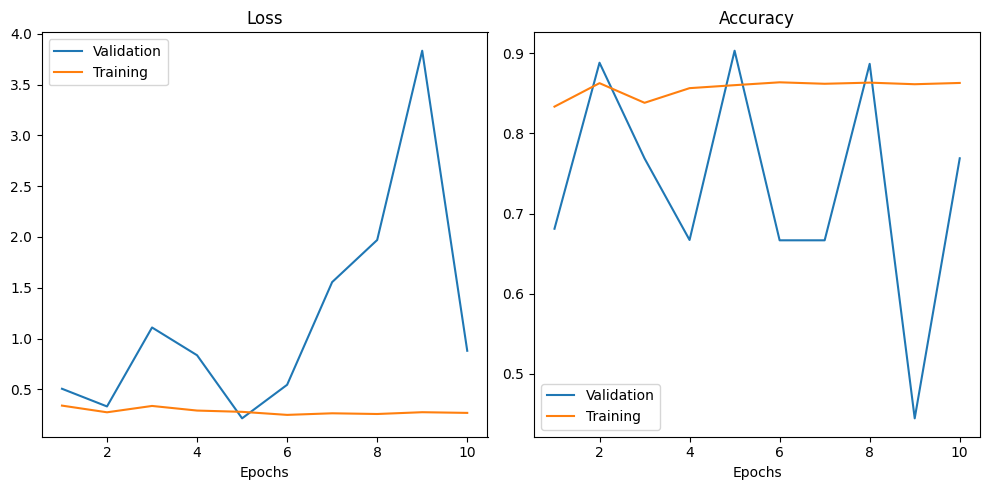

In [11]:
model_name = '20240213_113307'

# plot the training results
results = json.load(open(os.path.join('./models/', model_name, 'history.json')))

# create a new figure
fig = plt.figure(figsize=(10, 5))

# subplot 1
ax = plt.subplot(1, 2, 1)
plt.title("Loss")
ax.plot(range(1, len(results['val_loss'])+1), results['val_loss'], label='Validation')
ax.plot(range(1, len(results['loss'])+1), results['loss'], label='Training')
ax.set_xlabel("Epochs")
ax.legend()

# subplot 2
ax1 = plt.subplot(1, 2, 2)
plt.title("Accuracy")
ax1.plot(range(1, len(results['val_accuracy'])+1), results['val_accuracy'], label='Validation')
ax1.plot(range(1, len(results['accuracy'])+1), results['accuracy'], label='Training')
ax1.set_xlabel("Epochs")
ax1.legend()

plt.tight_layout()